# Dataset
In this homework, we will use the *New York City Airbnb Open Data*. You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv) or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv) if you don't want to sign up to Kaggle.

The goal of this homework is to create a regression model for prediction apartment prices (column `price`).

# EDA
* Load the data.
* Look at the price variable. Does it have a long tail?

<font color=red> Yes, it does! </font>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [34]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
data['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

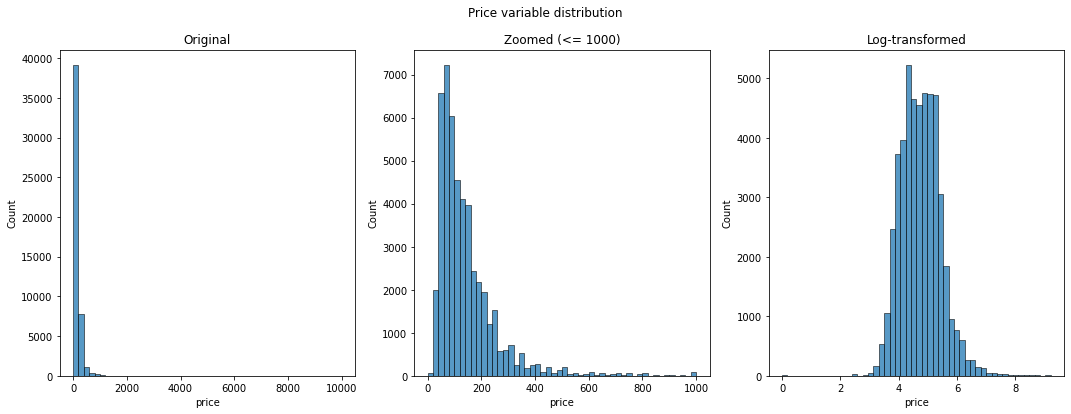

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
fig.suptitle('Price variable distribution')
sns.histplot(data['price'], bins=50, ax=ax[0])
ax[0].set_title('Original')
sns.histplot(data.loc[data['price'] <= 1000, 'price'], bins=50, ax=ax[1])
ax[1].set_title('Zoomed (<= 1000)')
sns.histplot(np.log1p(data['price']), bins=50, ax=ax[2])
ax[2].set_title('Log-transformed');

# Features
For the rest of the homework, you'll need to use only these columns:

* `latitude`,
* `longitude`,
* `price`,
* `minimum_nights`,
* `number_of_reviews`,
* `reviews_per_month`,
* `calculated_host_listings_count`,
* `availability_365`.

Select only them.

In [35]:
features = ['latitude',
            'longitude',
            'minimum_nights',
            'number_of_reviews',
            'reviews_per_month',
            'calculated_host_listings_count',
            'availability_365',
            'price']

data = data.loc[:, features]
data.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,40.64749,-73.97237,1,9,0.21,6,365,149
1,40.75362,-73.98377,1,45,0.38,2,355,225
2,40.80902,-73.94190,3,0,NaN,1,365,150
3,40.68514,-73.95976,1,270,4.64,1,194,89
4,40.79851,-73.94399,10,9,0.10,1,0,80


# Question 1

Find a feature with missing values. How many missing values does it have?

In [36]:
data.isna().sum()

latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price                                 0
dtype: int64

# Question 2

What's the median (50% percentile) for variable `minimum_nights`?

In [37]:
data['minimum_nights'].median()

3.0

# Split the data
* Shuffle the initial dataset, use `seed 42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value (`price`) is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [38]:
def split_data(data, test_size=0.2, val_size=0.2, seed=42):
    # data length
    n = len(data)
    # prepare array of indices 
    idx = np.arange(n)
    # setting numpy randomizer seed number
    np.random.seed(seed)
    # shuffle indices array randomly
    np.random.shuffle(idx)
    # get sizes of splits
    n_test = int(n * test_size)
    n_val = int(n * val_size)
    n_train = n - n_val - n_test
    
    # split data
    df_train = data.iloc[idx[:n_train]]
    df_val = data.iloc[idx[n_train:n_train + n_val]]
    df_test = data.iloc[idx[n_train + n_val:]]
    
    # Apply the log transformation and get target variable separated
    y_train = np.log1p(df_train['price'].values)
    y_val = np.log1p(df_val['price'].values)
    y_test = np.log1p(df_test['price'].values)
    
    # get data sets without target variable
    df_train = df_train.drop('price', axis=1).reset_index(drop=True)
    df_val = df_val.drop('price', axis=1).reset_index(drop=True)
    df_test = df_test.drop('price', axis=1).reset_index(drop=True)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [74]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(data)
print(f'Datasets sizes:\nTRAIN - {len(X_train)}\nTEST - {len(X_test)}\nVALIDATION - {len(X_val)}\n')
df_train.head()

Datasets sizes:
TRAIN - 29337
TEST - 9779
VALIDATION - 9779



,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64354,-73.97777,3,62,0.71,1,189
1,40.70666,-73.90779,21,0,NaN,1,73
2,40.76116,-73.99016,2,17,0.43,1,0
3,40.70763,-74.01050,2,5,1.88,327,272
4,40.79658,-73.93287,2,30,0.80,1,30


# Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lesssons.
* For computing the mean, use the training only!
* Compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [75]:
# function to train linear regression with regularization
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [83]:
# function to preprocess data
# by default, filling missing values with zero
def prepare_X(df, fill=0):
    X = df.copy()
    X = X.fillna(fill)

    return X.values

In [85]:
# fill missing values with 0
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

w0, w = train_linear_regression_reg(X_train, y_train, r=0.0)
y_pred = w0 + X_train.dot(w)
print('Train RMSE:', round(mean_squared_error(y_train, y_pred, squared=False), 2))
y_pred = w0 + X_val.dot(w)
print('Valid RMSE:', round(mean_squared_error(y_val, y_pred, squared=False), 2))

Train RMSE: 0.64
Valid RMSE: 0.64


In [88]:
# fill missing values with mean of the variable using train data set only
mean = df_train['reviews_per_month'].mean()
X_train = prepare_X(df_train, fill=mean)
X_val = prepare_X(df_val, fill=mean)

w0, w = train_linear_regression_reg(X_train, y_train, r=0.0)
y_pred = w0 + X_train.dot(w)
print('Train RMSE:', round(mean_squared_error(y_train, y_pred, squared=False), 2))
y_pred = w0 + X_val.dot(w)
print('Valid RMSE:', round(mean_squared_error(y_val, y_pred, squared=False), 2))

Train RMSE: 0.64
Valid RMSE: 0.64


# Question 4
* Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [98]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    score = mean_squared_error(y_val, y_pred, squared=False)
    print(f'Regularization: {r:6}, Validation RMSE: {score:.2f}')

Regularization:      0, Validation RMSE: 0.64
Regularization:  1e-06, Validation RMSE: 0.64
Regularization: 0.0001, Validation RMSE: 0.64
Regularization:  0.001, Validation RMSE: 0.64
Regularization:   0.01, Validation RMSE: 0.66
Regularization:    0.1, Validation RMSE: 0.68
Regularization:      1, Validation RMSE: 0.68
Regularization:      5, Validation RMSE: 0.68
Regularization:     10, Validation RMSE: 0.68


# Question 5
* We used `seed 42` for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits `(round(std, 3))`
> Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is *stable*.

In [108]:
scores = list()
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, _, y_train, y_val, _ = split_data(data, seed=seed)
    X_train = prepare_X(df_train)
    X_val = prepare_X(df_val)
    w0, w = train_linear_regression_reg(X_train, y_train, r=0.0)
    y_pred = w0 + X_val.dot(w)
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(score)
    print(f'Seed: {seed}, Validation RMSE: {score:.4f}')

print('Standard deviation of scores: ', round(np.std(scores), 3))

Seed: 0, Validation RMSE: 0.6550
Seed: 1, Validation RMSE: 0.6463
Seed: 2, Validation RMSE: 0.6477
Seed: 3, Validation RMSE: 0.6375
Seed: 4, Validation RMSE: 0.6446
Seed: 5, Validation RMSE: 0.6306
Seed: 6, Validation RMSE: 0.6298
Seed: 7, Validation RMSE: 0.6506
Seed: 8, Validation RMSE: 0.6490
Seed: 9, Validation RMSE: 0.6438
Standard deviation of scores:  0.008


# Question 6
* Split the dataset like previously, use `seed 9`.
* Combine train and validation datasets.
* Train a model with `r=0.001`.
* What's the RMSE on test dataset?

In [111]:
df_train, df_val, df_test, y_train, y_val, y_test = split_data(data, seed=9)
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
X_test = prepare_X(df_test)

X = np.vstack((X_train, X_val))
y = np.hstack((y_train, y_val))

w0, w = train_linear_regression_reg(X, y, r=0.001)
y_pred = w0 + X_test.dot(w)
score = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE on test dataset: {score:.4f}')

RMSE on test dataset: 0.6453


<blockquote class="twitter-tweet"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/DataTalksClub?src=hash&amp;ref_src=twsrc%5Etfw">#DataTalksClub</a> <a href="https://twitter.com/hashtag/MLZoomcamp?src=hash&amp;ref_src=twsrc%5Etfw">#MLZoomcamp</a> Second homework with &quot;price of AirBnB apartments in NYC&quot; dataset done!</p>&mdash; sha of smile (@trueRock_n_roll) <a href="https://twitter.com/trueRock_n_roll/status/1437721647067369476?ref_src=twsrc%5Etfw">September 14, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>